In [1]:
import pandas as pd
import numpy as np
import sqlite3 
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

## Exploring ROI per genre 
This section will explore which genre will have the highest ROI with a lower budget since this will be our first foray in the film industry

In [2]:
df_gross = pd.read_csv('../data/cleaned_movie_gross.csv', index_col=0)
df_budgets = pd.read_csv('../data/cleaned_budgets.csv', index_col=0)
df_movies = pd.read_csv('../data/cleaned_movies.csv', index_col=0)
conn = sqlite3.connect('../data/im.db')

In [3]:
df_gross

,studio,domestic_gross,foreign_gross,year
title,,,,
Toy Story 3,BV,415000000.00,652000000,2010
Alice in Wonderland (2010),BV,334200000.00,691300000,2010
Harry Potter and the Deathly Hallows Part 1,WB,296000000.00,664300000,2010
Inception,WB,292600000.00,535700000,2010
Shrek Forever After,P/DW,238700000.00,513900000,2010
...,...,...,...,...
The Quake,Magn.,6200.00,NaN,2018
Edward II (2018 re-release),FM,4800.00,NaN,2018
El Pacto,Sony,2500.00,NaN,2018


df_gross and df_budgets seem to essentially store the same data, though df_gross has the added row of studio. We'll look at the budgets table two ways, one looking at the return_ratio and another at the raw gross number

In [4]:
df_budgets['release_date'] = pd.to_datetime(df_budgets['release_date'])
df_budgets

,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_ratio
id,,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279,5.53
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,1.55
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-0.57
4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,3.24
5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,3.15
...,...,...,...,...,...,...
77,2004-12-31,The Mongol King,7000,900,900,-0.87
78,2018-12-31,Red 11,7000,0,0,-1.00
80,2005-07-13,Return to the Land of Wonders,5000,1338,1338,-0.73


We'll settle on a budget of 2 million since at the budget, the movies still averaged around a 100 roi

In [5]:
df_high_return = df_budgets.sort_values('return_ratio', ascending=False).head(30)
df_high_return.mean(numeric_only=True)

production_budget     1929436.67
domestic_gross       51048412.47
worldwide_gross     110674630.43
return_ratio              105.35
dtype: float64

In [6]:
df_high_gross = df_budgets.sort_values('worldwide_gross', ascending=False).head(20)
df_high_gross.mean(numeric_only=True)

production_budget    217080000.00
domestic_gross       509391552.15
worldwide_gross     1454594828.85
return_ratio                 6.46
dtype: float64

When comparing the averages we can see that there is a pretty disparity between the highest grossing, and the highest return ratio movies. The highest return ratio movies average a significantly lower production budget while the opposite is true for the highest grossing movies. Since we are a new studio, I think it is a good idea to pay attention to the lower production budget movies with a high return ratio. 

In [9]:
df_top_return = df_budgets.sort_values('return_ratio', ascending=False)
df_top_return = df_top_return[(df_top_return['production_budget'] < 2000000) & (df_top_return['worldwide_gross'] > 0) & (df_top_return['return_ratio'] > 2)]
#df_top_return = df_top_return[(df_top_return['production_budget'] < 200000000) & (df_top_return['production_budget'] > 125000000) & (df_top_return['worldwide_gross'] >)]
df_top_return.rename(columns={'movie': 'primary_title'}, inplace=True)
top_return_movies = df_top_return['primary_title'].to_list()

Since we're looking at the movies with the highest returns, we'll also filter on a max of 1,000,000 for budget since that was the average for the top 20 highest return movies. The movies will also need to have a return_ratio greater than 1.

In [ ]:
df_budgets['release_date'].groupby(df_budgets.release_date.dt.year).count()

release_date
2000    189
2001    181
2002    210
2003    201
2004    206
2005    223
2006    260
2007    220
2008    264
2009    239
2010    274
2011    254
2012    235
2013    238
2014    255
2015    338
2016    219
2017    168
2018    143
2019     67
2020      3
Name: release_date, dtype: int64

We can also see that this dataset when grouped by years, has less movies in recent years. This could very well be a limitation of the dataset, but we can also see that the number starts decreasing at around 2015. This could be a result of streaming services being more enticing to studios and as a result releasing less movies in theaters. 

Next we will look at the sql database so that we can see if we can get more data for each movie

In [ ]:
pd.read_sql(
"""
SELECT name
FROM sqlite_master
WHERE type='table'            
""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


Given the top return movies from above, if we look for those from the sql database, the genres column could be a useful entrant.

In [ ]:
#Get the rows that exist in the list from above
query = "SELECT * FROM movie_basics WHERE primary_title in " + str(tuple(top_return_movies))

df_genre = pd.read_sql(query, conn)
df_genre

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0326592,The Overnight,The Overnight,2010,88.00,None
1,tt10227710,Brick,Brick,2019,93.00,"Drama,Family,Romance"
2,tt1120985,Blue Valentine,Blue Valentine,2010,112.00,"Drama,Romance"
3,tt1320244,The Last Exorcism,The Last Exorcism,2010,87.00,"Drama,Horror,Thriller"
4,tt1366338,Lowriders,Lowriders,2016,98.00,"Adventure,Crime,Drama"
...,...,...,...,...,...,...
91,tt8681390,Like Crazy,Like Crazy,2018,NaN,Drama
92,tt8883462,Home,Home,2017,NaN,"Drama,Family"
93,tt9248762,The Terrorist,The Terrorist,2018,NaN,Thriller
94,tt9281490,Home,Home,2018,50.00,Documentary


Here we create a dictionary that counts the number of genres and sort them by which appears the most

In [ ]:
#Get the genres as a list
genre_count = df_genre['genres'].str.split(',').to_list()
#Create a dictionary of genres and their counts, ignore occasional none values
genre_dict = {}
for genres in genre_count:
    if genres != None:
        for genre in genres:
            if genre in genre_dict:
                genre_dict[genre] += 1
            else:
                genre_dict[genre] = 1
        

In [ ]:
genre_dict = dict(sorted(genre_dict.items(), key=lambda item: item[1], reverse=True))
genre_dict

{'Drama': 51,
 'Horror': 19,
 'Comedy': 18,
 'Documentary': 18,
 'Romance': 17,
 'Thriller': 15,
 'Mystery': 12,
 'Family': 5,
 'Sci-Fi': 5,
 'Biography': 5,
 'Adventure': 4,
 'Crime': 4,
 'Action': 4,
 'History': 3,
 'Fantasy': 2,
 'Animation': 2,
 'Music': 1,
 'War': 1}

Dramas are the most common

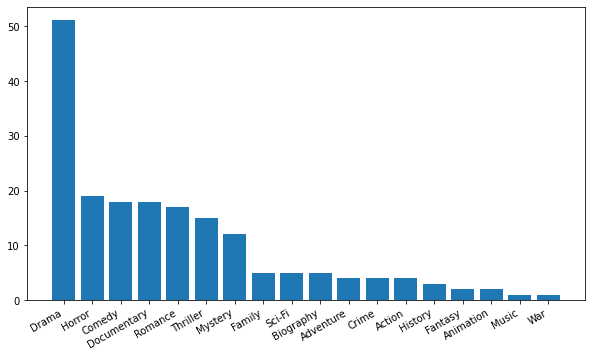

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(genre_dict.keys(), genre_dict.values())
fig.autofmt_xdate()

Next we'll find the movies from before in the sql database so that we can combine the dataframes and get a better picture 

In [ ]:
pd.read_sql(
"""
SELECT *
from movie_ratings
join movie_basics
using(movie_id)
where primary_title in 
"""+ str(tuple(top_return_movies)), conn)

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0326592,7.50,24,The Overnight,The Overnight,2010,88.00,None
1,tt1120985,7.40,170089,Blue Valentine,Blue Valentine,2010,112.00,"Drama,Romance"
2,tt1320244,5.60,45815,The Last Exorcism,The Last Exorcism,2010,87.00,"Drama,Horror,Thriller"
3,tt1366338,5.70,1954,Lowriders,Lowriders,2016,98.00,"Adventure,Crime,Drama"
4,tt1441326,6.90,45873,Martha Marcy May Marlene,Martha Marcy May Marlene,2011,102.00,"Drama,Mystery,Thriller"
...,...,...,...,...,...,...,...,...
61,tt6265828,6.80,46280,A Ghost Story,A Ghost Story,2017,92.00,"Drama,Fantasy,Romance"
62,tt7153766,6.40,32049,Unsane,Unsane,2018,98.00,"Drama,Horror,Mystery"
63,tt8161226,5.80,244,All You Need Is Love,All You Need Is Love,2018,113.00,"Comedy,Romance"
64,tt8601408,8.40,32,Home,Dom,2018,71.00,"Drama,Romance,Thriller"


In [ ]:
df_movies[df_movies['original_title'].isin(top_return_movies)]

,original_language,original_title,popularity,release_date,title,vote_average,vote_count
id,,,,,,,
26388,en,Buried,10.89,2010-09-24,Buried,6.60,1487
43933,en,Monsters,10.18,2010-10-29,Monsters,6.20,848
38358,en,The Last Exorcism,9.35,2010-08-27,The Last Exorcism,5.60,519
46705,en,Blue Valentine,8.99,2010-12-29,Blue Valentine,6.90,1677
33511,en,Nowhere Boy,7.10,2010-01-27,Nowhere Boy,7.30,469
...,...,...,...,...,...,...,...
347882,en,Sleight,5.66,2017-04-28,Sleight,5.30,367
333384,en,Lowriders,4.96,2017-05-12,Lowriders,6.50,46
496256,en,Home,0.60,2017-04-30,Home,4.00,1


We'll combine the sql database with the top return movies we found earlier so that we can attribute genres with a return ratio

In [ ]:
df_genre_return = pd.merge(df_genre, df_top_return[['primary_title', 'return_ratio', 'production_budget']], on=['primary_title'], how='left')
genre_list = df_genre_return['genres'].str.split(',').to_list()
return_list = df_genre_return['return_ratio'].to_list()
budget_list = df_genre_return['production_budget'].to_list()
df_genre_return

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,return_ratio,production_budget
0,tt0326592,The Overnight,The Overnight,2010,88.00,None,4.83,200000
1,tt10227710,Brick,Brick,2019,93.00,"Drama,Family,Romance",8.43,450000
2,tt1120985,Blue Valentine,Blue Valentine,2010,112.00,"Drama,Romance",15.57,1000000
3,tt1320244,The Last Exorcism,The Last Exorcism,2010,87.00,"Drama,Horror,Thriller",37.98,1800000
4,tt1366338,Lowriders,Lowriders,2016,98.00,"Adventure,Crime,Drama",5.76,916000
...,...,...,...,...,...,...,...,...
91,tt8681390,Like Crazy,Like Crazy,2018,NaN,Drama,13.91,250000
92,tt8883462,Home,Home,2017,NaN,"Drama,Family",88.59,500000
93,tt9248762,The Terrorist,The Terrorist,2018,NaN,Thriller,6.80,25000
94,tt9281490,Home,Home,2018,50.00,Documentary,88.59,500000


In [ ]:
df_genre_return.mean(numeric_only=True)

start_year            2013.61
runtime_minutes         84.61
return_ratio            37.36
production_budget   654676.56
dtype: float64

In [ ]:
def moving_average(curr_avg, num, count):
    curr_avg + (num - curr_avg)/ count
    return curr_avg

In [ ]:
genre_roi = {}

#Ugly function to calculate the average roi for each genre
for genres, roi, budget in zip(genre_list, return_list, budget_list):
    if genres != None:
        for genre in genres:
            if genre in genre_roi:
                #calculate average roi
                curr_avg = genre_roi[genre]['average_roi']
                num = roi
                count = genre_roi[genre]['count']
                genre_roi[genre]['average_roi'] = moving_average(curr_avg, num, count)
                #calculate average budget
                budg_avg = genre_roi[genre]['average_cost']
                b_num = budget
                genre_roi[genre]['average_cost'] = moving_average(budg_avg, b_num, count)
                genre_roi[genre]['count'] += 1
            else:
                genre_roi[genre] = {'average_roi' : roi, 'average_cost': budget, 'count': 1}

Here we get a breakdown of the return ratios for all the genres that occur in our dataset, though some have very low counts, we will have to decide if we still keep those or if we expand our scope to include more movies.

In [ ]:
genre_roi = dict(sorted(genre_roi.items(), key=lambda item: item[1]['average_roi'], reverse=True))
genre_roi

{'Animation': {'average_roi': 88.59, 'average_cost': 500000, 'count': 2},
 'War': {'average_roi': 88.59, 'average_cost': 500000, 'count': 1},
 'Horror': {'average_roi': 37.98, 'average_cost': 1800000, 'count': 19},
 'Thriller': {'average_roi': 37.98, 'average_cost': 1800000, 'count': 15},
 'Fantasy': {'average_roi': 11.93, 'average_cost': 1800000, 'count': 2},
 'Biography': {'average_roi': 10.5, 'average_cost': 1000000, 'count': 5},
 'Sci-Fi': {'average_roi': 10.28, 'average_cost': 500000, 'count': 5},
 'History': {'average_roi': 10.28, 'average_cost': 500000, 'count': 3},
 'Drama': {'average_roi': 8.43, 'average_cost': 450000, 'count': 51},
 'Family': {'average_roi': 8.43, 'average_cost': 450000, 'count': 5},
 'Romance': {'average_roi': 8.43, 'average_cost': 450000, 'count': 17},
 'Comedy': {'average_roi': 7.48, 'average_cost': 50000, 'count': 18},
 'Action': {'average_roi': 7.3, 'average_cost': 190000, 'count': 4},
 'Adventure': {'average_roi': 5.76, 'average_cost': 916000, 'count': 

We will remove genres that have less than 3 movies

In [ ]:
genre_roi = {k:v for k,v in genre_roi.items() if v['count'] > 2}

{'Horror': {'average_roi': 37.98, 'average_cost': 1800000, 'count': 19},
 'Thriller': {'average_roi': 37.98, 'average_cost': 1800000, 'count': 15},
 'Biography': {'average_roi': 10.5, 'average_cost': 1000000, 'count': 5},
 'Sci-Fi': {'average_roi': 10.28, 'average_cost': 500000, 'count': 5},
 'History': {'average_roi': 10.28, 'average_cost': 500000, 'count': 3},
 'Drama': {'average_roi': 8.43, 'average_cost': 450000, 'count': 51},
 'Family': {'average_roi': 8.43, 'average_cost': 450000, 'count': 5},
 'Romance': {'average_roi': 8.43, 'average_cost': 450000, 'count': 17},
 'Comedy': {'average_roi': 7.48, 'average_cost': 50000, 'count': 18},
 'Action': {'average_roi': 7.3, 'average_cost': 190000, 'count': 4},
 'Adventure': {'average_roi': 5.76, 'average_cost': 916000, 'count': 4},
 'Crime': {'average_roi': 5.76, 'average_cost': 916000, 'count': 4},
 'Mystery': {'average_roi': 4.44, 'average_cost': 1000000, 'count': 12},
 'Documentary': {'average_roi': 3.93, 'average_cost': 225000, 'count'

We see that horror and thriller have by far the highest return on investment numbers on the graph

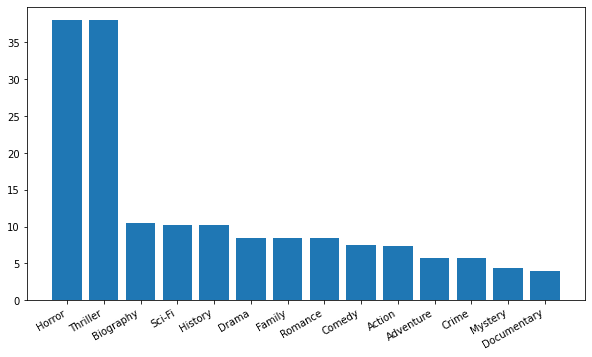

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(genre_roi.keys(), [x['average_roi'] for x in genre_roi.values()])
fig.autofmt_xdate()

I'll turn this dictionary into a df so it can be written and used for visualization

In [ ]:
df_genre_roi = pd.DataFrame.from_dict(genre_roi, orient='index').reset_index()
df_genre_roi.rename(columns={'index': 'genre'}, inplace=True)
df_genre_roi

,genre,average_roi,average_cost,count
0,Horror,37.98,1800000,19
1,Thriller,37.98,1800000,15
2,Biography,10.50,1000000,5
3,Sci-Fi,10.28,500000,5
4,History,10.28,500000,3
5,Drama,8.43,450000,51
6,Family,8.43,450000,5
7,Romance,8.43,450000,17
8,Comedy,7.48,50000,18
9,Action,7.30,190000,4


In [ ]:
df_genre_roi.to_csv('../data/genre_roi.csv', encoding='utf-8')